# Monero Feature Engineering: Derived Indicators

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import SMAIndicator, EMAIndicator
from scipy.stats import entropy
import os


In [11]:
input_path = "../data/raw/kraken_xmr_ohlcv.csv"
output_path = "../data/processed/xmr_features.csv"
df = pd.read_csv(input_path, parse_dates=["time"])
df.sort_values("time", inplace=True)
df.head()


,time,open,high,low,close,vwap,volume
0,2023-05-31,153.08,153.63,145.05,145.99,148.75,6270.255826
1,2023-06-01,145.78,148.70,145.50,146.47,146.42,8850.617087
2,2023-06-02,146.45,147.50,145.00,146.16,145.83,3407.775301
3,2023-06-03,145.91,148.60,145.77,148.47,147.21,3288.391910
4,2023-06-04,148.19,150.05,147.95,148.29,148.80,4684.823787


In [12]:
# --- Moving Averages ---
df["sma_20"] = SMAIndicator(close=df["close"], window=20).sma_indicator()
df["ema_20"] = EMAIndicator(close=df["close"], window=20).ema_indicator()

# --- RSI ---
df["rsi_14"] = RSIIndicator(close=df["close"], window=14).rsi()

# --- Bollinger Bands ---
bb = BollingerBands(close=df["close"], window=20, window_dev=2)
df["bb_bbm"] = bb.bollinger_mavg()
df["bb_bbh"] = bb.bollinger_hband()
df["bb_bbl"] = bb.bollinger_lband()
df["bb_width"] = df["bb_bbh"] - df["bb_bbl"]

# --- Log Returns + Volatility ---
df["log_return"] = np.log(df["close"] / df["close"].shift(1))
df["volatility_14"] = df["log_return"].rolling(window=14).std()

# --- Entropy ---
def calc_entropy(series, bins=10):
    hist, _ = np.histogram(series, bins=bins, density=True)
    return entropy(hist + 1e-9)

df["entropy_14"] = df["log_return"].rolling(window=14).apply(calc_entropy, raw=False)
df.dropna(inplace=True)
df.head()


,time,open,high,low,close,vwap,volume,sma_20,ema_20,rsi_14,bb_bbm,bb_bbh,bb_bbl,bb_width,log_return,volatility_14,entropy_14
19,2023-06-19,137.42,139.30,136.30,138.28,137.70,3772.556953,141.1310,139.911456,43.020349,141.1310,150.789078,131.472922,19.316157,0.007622,0.020492,1.673118
20,2023-06-20,138.11,142.78,137.32,141.85,140.33,4784.566366,140.9240,140.096079,52.009748,140.9240,150.330832,131.517168,18.813665,0.025490,0.018334,1.970181
21,2023-06-21,141.57,145.90,141.18,145.12,143.98,6826.727165,140.8565,140.574548,58.472415,140.8565,150.121484,131.591516,18.529968,0.022791,0.019204,1.871160
22,2023-06-22,145.26,153.05,145.19,149.92,148.95,10124.191272,141.0445,141.464591,65.761204,141.0445,150.868071,131.220929,19.647141,0.032541,0.020311,1.945910
23,2023-06-23,149.92,155.46,149.04,154.53,151.88,7365.642440,141.3475,142.708915,71.021795,141.3475,152.369271,130.325729,22.043542,0.030286,0.021528,1.970181


In [13]:
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"Feature file saved to: {output_path}")


Feature file saved to: ../data/processed/xmr_features.csv


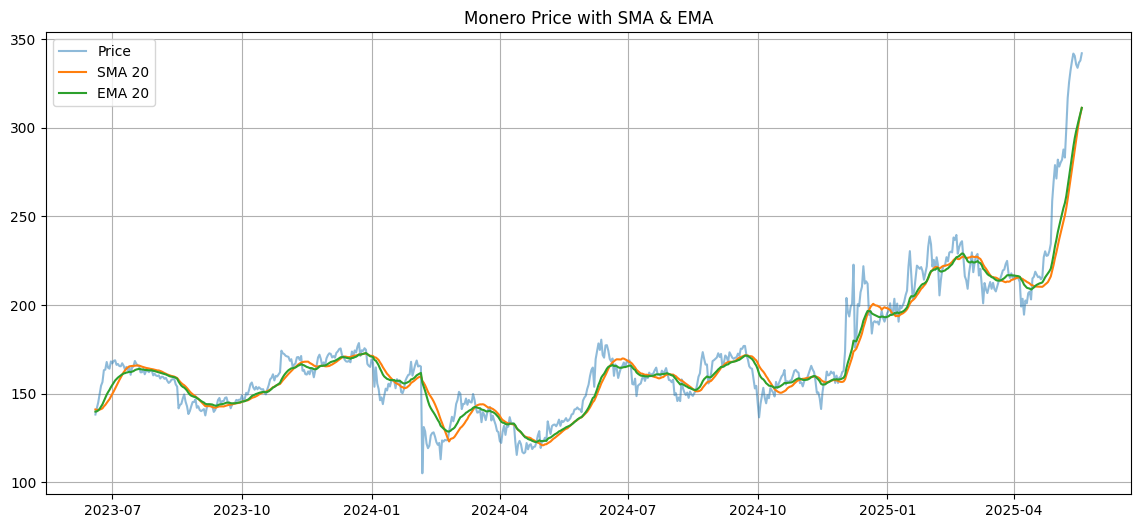

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(df["time"], df["close"], label="Price", alpha=0.5)
plt.plot(df["time"], df["sma_20"], label="SMA 20")
plt.plot(df["time"], df["ema_20"], label="EMA 20")
plt.title("Monero Price with SMA & EMA")
plt.legend()
plt.grid(True)
plt.show()
